## 1. Imports and Setup
We import necessary libraries and set up custom plot configurations for consistency.

In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye
import From_data_to_binary
from Data_class1 import Data
from IPython.display import display
import pickle
from mpl_toolkits.basemap import Basemap
import os


In [50]:
# Download Air2m_northern_JJA.npy and Air2m_northern_DJF.npy 
# from https://doi.org/10.5281/zenodo.14016472 and place them in the DATA folder

## 2. Data  Preparation


In [2]:
def degree_to_longitude(degree):
    """Converts a degree value to a longitude label."""
    if degree == 0 or degree == 180 or degree == 360:
        return f"{degree}°"
    elif degree < 180:
        return f"{degree}°E"
    else:
        return f"{360 - degree}°W"
    
def load_and_process_data(file_name, crit_value):
    """Loads and processes the data from a file, returning the raw and processed data."""
    data = np.load(file_name)
    processed_data = [
        (np.sum(data[key] > crit_value, axis=1).mean(axis=1), 
         np.sum(data[key] > crit_value, axis=1).std(axis=1))
        for key in ['anomalies_numb_past', 'anomalies_numb_future', 
                    'anomalies_numb_past_detr', 'anomalies_numb_future_detr']
    ]
    return data, processed_data

def plot_anomalies(ax, x, means_stds, title, ylim, labels, plt_y_label):
    """Plots the anomalies with means and standard deviations."""
    colors = ['darkorange', 'limegreen']
    for i in range(2):
        mean, std = means_stds[i]
        ax.plot(x, mean, linewidth=3, marker='o' if i == 0 else 's', markersize=10, 
                linestyle='-' if i == 0 else '--', label=labels[i], color=colors[i])
        ax.fill_between(x, mean - std, mean + std, color=colors[i], alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('Longitude',fontsize=17)
    if plt_y_label:
        display(plt_y_label)
        ax.set_ylabel('Fraction of Anomalous Days',fontsize=17)
    ax.set_ylim(ylim)
    ax.set_xticks(np.arange(0, 361, 30))
    ax.set_xticklabels([degree_to_longitude(deg) for deg in np.arange(0, 361, 30)])
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=17, length=10, width=2)
    ax.tick_params(axis='both', which='minor', length=5, width=1)
    ax.legend()

def find_anomalous_indices(data, crit_value, threshold, discretization_step=10):
    """Finds indices of anomalies exceeding the critical value and threshold."""
    keys = ['anomalies_numb_past_detr', 'anomalies_numb_future_detr']
    result = {key: {} for key in keys}

    # Calculate the total number of longitude points
    total_longitudes = data['anomalies_numb_past_detr'].shape[0]

    # Define longitude labels based on discretization step and total points
    longitudes = [degree_to_longitude(deg) for deg in np.arange(0, 360, discretization_step)]

    for key in keys:
        anomalies = data[key]
        # Iterate over the longitudes
        for i in range(total_longitudes):
            lon_label = longitudes[i]
            # Get the indices along axis 1 where the value is greater than crit_value
            condition_indices = np.where(anomalies[i, :, -1] > crit_value)[0]
            # Check if the count of such indices is greater than the threshold
            if len(condition_indices) > threshold:
                # Store indices and their corresponding anomaly values
                result[key][lon_label] = {
                    'indices': condition_indices.tolist(),
                    'anomalies': anomalies[i, condition_indices, -1].tolist()
                }

    return result
#%%
def get_longitude_indices(center_deg, window_width_deg, discretization_step=2.5):
    total_points = int(360 / discretization_step)
    center_idx = int(center_deg / discretization_step) % total_points
    half_window_idx = int(window_width_deg / (2 * discretization_step))
    start_idx = (center_idx - half_window_idx) % total_points
    end_idx = (center_idx + half_window_idx + 1) % total_points

    if start_idx < end_idx:
        longi = list(range(start_idx, end_idx))
    else:
        longi = list(range(start_idx, total_points)) + list(range(0, end_idx))

    return longi, len(longi)




#%% function to compute the NLPval
def compute_upsilon_values(binary_sequences, kstar_range, num_cores):
    p_value_data = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range, num_cores = num_cores).smallest_pval_info
    
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    return upsilon_values, kstar_values
#%%

def visualize_microstate_mean_AIR2M(ax, tbp, longi, color_local, max_NLPval_NearNeigh):
    """
    Plot atmospheric data using Basemap with specific overlays indicating different regions.
    - ax: Matplotlib axis object where the plot will be drawn.
    - tbp: 2D array of data to plot.
    - longi: List of longitude indices for specific plotting regions.
    - color_local: Color used for highlighting specific features.
    """
    m = Basemap(projection='ortho', lat_0=90, lon_0=0, resolution='l', ax=ax)
    m.shadedrelief()
    m.drawlsmask(land_color='silver', ocean_color='white', lakes=True)
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(0, 90 + 1, 15.), labels=[1, 0, 0, 0], fontsize=0, linewidth=1.5)
    m.drawmeridians(np.arange(0., 360, 30.), labels=[0, 0, 0, 1], fontsize=0, linewidth=1.5)

    scale = 2.5
    longi1 = list(range(0, 144)) + list(range(1))
    y = np.arange(0, 91, scale)
    x = np.arange(0,361, scale)
    # longi = (list(range(0,144)) + list(range(1)))#(list(range(120,144)) + list(range(0,121)))
    X, Y = np.meshgrid(x, y)

    if np.abs(tbp.max())<17:
        p1 = -15
        p97 = 15
        dp = (p97 - p1)/240
    else:
        p1 = -45
        p97 = 45
        dp = (p97 - p1)/240

    # dp = int((p97 - p1) / 1000)
    levels1 = np.arange(p1, p97, dp)
    x1, y1 = m(X, Y)
    CS = ax.contourf(x1, y1, tbp[:, longi1], levels=levels1, alpha=1, cmap='seismic')

    x2, y2 = m(X[13:30, [longi[0], longi[-1]]], Y[13:30, [longi[0], longi[-1]]])
    ax.plot(x2[:, 0], y2[:, 0], c='limegreen', linewidth=3.5)
    ax.plot(x2[:, 1], y2[:, 1], c='limegreen', linewidth=3.5)
    if longi[-1] < longi[0]:
        x2, y2 = m(X[[13, 29], :][:, range(longi[0]-144-1 , longi[-1]+ 1, 1)], Y[[13, 29], :][:, range(longi[0]-144-1, longi[-1] + 1, 1)])
        ax.plot(x2[0, :], y2[0, :], c='limegreen', linewidth=3.5)
        ax.plot(x2[1, :], y2[1, :], c='limegreen', linewidth=3.5)
    else:
        x2, y2 = m(X[[13, 29], :][:, range(longi[0], longi[-1] + 1, 1)], Y[[13, 29], :][:, range(longi[0], longi[-1] + 1, 1)])
        ax.plot(x2[0, :], y2[0, :], c='limegreen', linewidth=3.5)
        ax.plot(x2[1, :], y2[1, :], c='limegreen', linewidth=3.5)

    x2, y2 = m(X[[0, 3], :][:, range(0, 144, 1)], Y[[0, 3], :][:, range(0, 144, 1)])
    ax.plot(x2[1, :], y2[1, :], c=color_local, linewidth=5)

    ax.set_title('Air2m_'+degree_to_longitude(int(longi[int(len(longi)/2)]*2.5)) + ': average over ' + str(max_NLPval_NearNeigh) + ' days')


## 3. Computation and Visualization


In [ ]:
K_M            = 100
NUM_CORES      = 16
NEIGHBOR_RANGE = range(4, K_M)

np.random.seed(7)
bernoulli_matrix = np.random.binomial(n=1, p=0.5, size=(200000, K_M))
NLPval_bernulli, kstar_bernulli = compute_upsilon_values(bernoulli_matrix, kstar_range=NEIGHBOR_RANGE, num_cores= NUM_CORES)
quantiles = [ 0.999, 0.9995, 0.9999, 0.99995,0.99999]
quantiles_tbp = np.quantile( NLPval_bernulli, quantiles )  
np.random.seed()
crit_value=quantiles_tbp[1]

/tmp/ipykernel_70384/845704765.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
/tmp/ipykernel_70384/845704765.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
/tmp/ipykernel_70384/845704765.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 4), (1, 0))
/tmp/ipykernel_70384/845704765.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4 = plt.sub

True

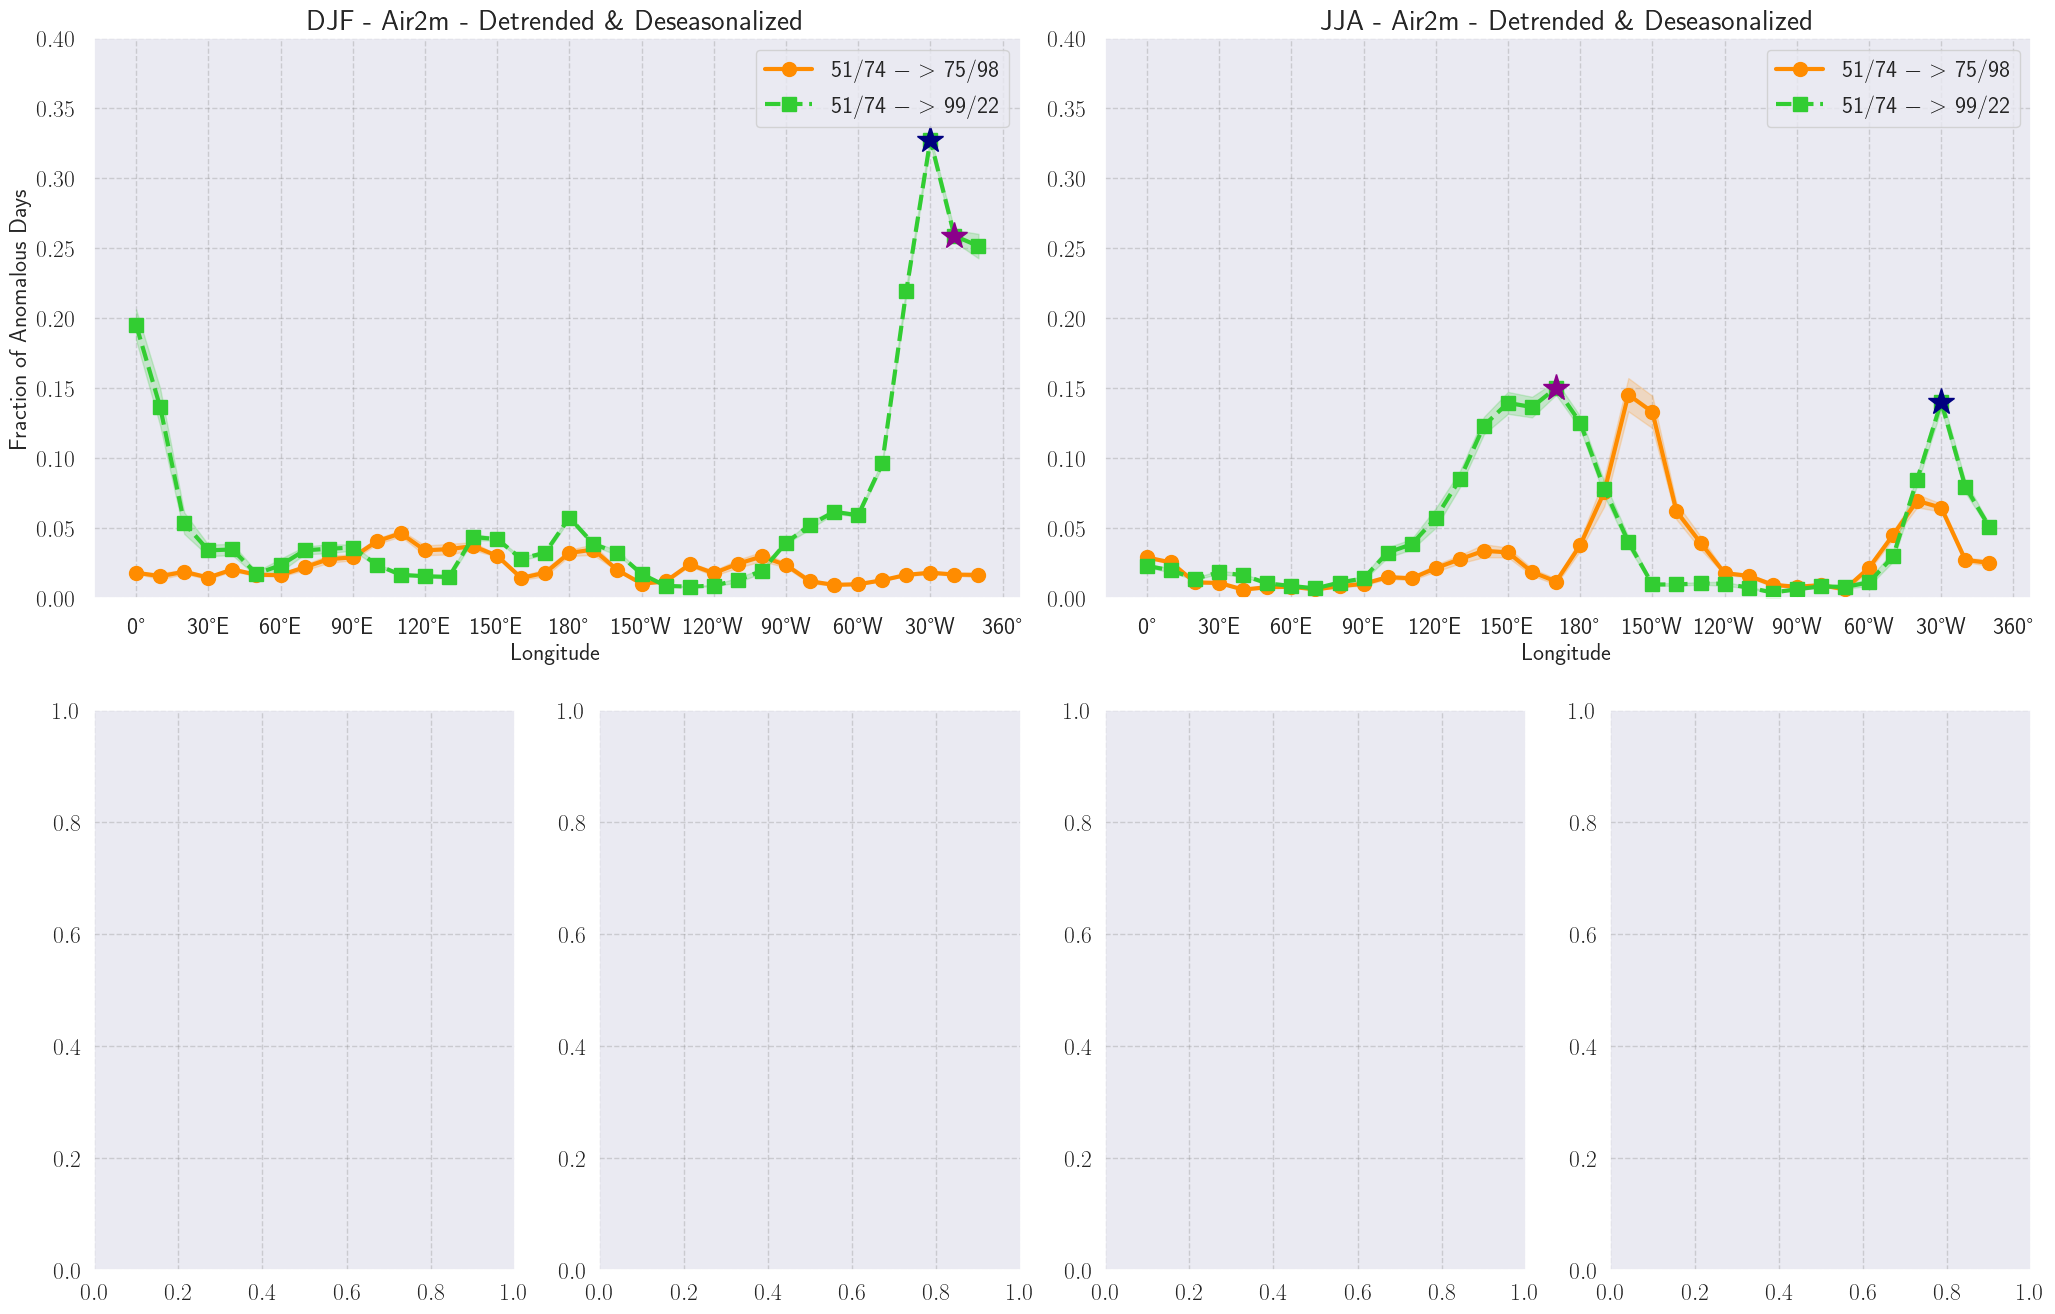

In [47]:
#%%

from pathlib import Path

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set up custom styles for the plots
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})
colors = ['navy', 'darkorange', 'limegreen', 'magenta','red','darkmagenta']

# Create 5x3 grid for the plots
fig, axs = plt.subplots(2, 4, figsize=(25, 16))
# First row with 2 subplots
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)

# Second row with 4 subplots
ax3 = plt.subplot2grid((2, 4), (1, 0))
ax4 = plt.subplot2grid((2, 4), (1, 1))
ax5 = plt.subplot2grid((2, 4), (1, 2))
ax6 = plt.subplot2grid((2, 4), (1, 3))




anomaly_threshold = 30
discretization_step = 10
seasonal_anomalies = {}
x = np.arange(0, 360, 10)  # Match the discretization step to the data's resolution
ylim = [0,.4]
file_name = 'DATA/anomalies_Air2m_data_NLPval_EE3_Winter.npz'

season = 'DJF'
data, means_stds = load_and_process_data(file_name, crit_value)
numb_days = data['anomalies_numb_future_detr'].shape[1]
anomalies_indices = find_anomalous_indices(data, crit_value, anomaly_threshold, discretization_step=discretization_step)
seasonal_anomalies[season] = anomalies_indices
plot_anomalies(ax1, x, np.array(means_stds[2:])/numb_days, f'{season} - Air2m - Detrended \\& Deseasonalized ', ylim, ['51/74 $->$ 75/98', '51/74 $->$ 99/22'],plt_y_label=True)
ax1.plot( 330, (np.array(means_stds[2:])/numb_days)[1,0,33], marker='*', linewidth=50, markersize=20,c='navy')
ax1.plot( 340, (np.array(means_stds[2:])/numb_days)[1,0,34], marker='*', linewidth=50, markersize=20,c='darkmagenta')


file_name = 'DATA/anomalies_Air2m_data_NLPval_EE3_Summer.npz'

season = 'JJA'
data, means_stds = load_and_process_data(file_name, crit_value)
anomalies_indices = find_anomalous_indices(data, crit_value, anomaly_threshold, discretization_step=discretization_step)
seasonal_anomalies[season] = anomalies_indices
plot_anomalies(ax2, x, np.array(means_stds[2:])/numb_days, f'{season} - Air2m - Detrended \\& Deseasonalized ', ylim, ['51/74 $->$ 75/98', '51/74 $->$ 99/22'],plt_y_label=False)
ax2.plot( 330, (np.array(means_stds[2:])/numb_days)[1,0,33], marker='*', linewidth=50, markersize=20,c='navy')
ax2.plot( 170, (np.array(means_stds[2:])/numb_days)[1,0,17], marker='*', linewidth=50, markersize=20,c='darkmagenta')




/tmp/ipykernel_70384/539795234.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
/tmp/ipykernel_70384/539795234.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
/tmp/ipykernel_70384/539795234.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 4), (1, 0))
/tmp/ipykernel_70384/539795234.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4 = plt.sub

Processing partition 1/22
Processing partition 2/22
Processing partition 3/22
Processing partition 4/22
Processing partition 5/22
Processing partition 6/22
Processing partition 7/22
Processing partition 10/22
Processing partition 8/22
Processing partition 9/22
Processing partition 12/22
Processing partition 22/22
Processing partition 11/22
Processing partition 14/22
Processing partition 13/22
Processing partition 15/22
Processing partition 17/22
Processing partition 18/22
Processing partition 20/22
Processing partition 16/22
Processing partition 19/22
Processing partition 21/22
Processing partition 1/16 completed.
Processing partition 2/16 completed.
Processing partition 3/16 completed.
Processing partition 4/16 completed.
Processing partition 5/16 completed.
Processing partition 6/16 completed.
Processing partition 7/16 completed.
Processing partition 8/16 completed.
Processing partition 9/16 completed.
Processing partition 10/16 completed.
Processing partition 11/16 completed.
Proces

77

Processing partition 1/22
Processing partition 2/22
Processing partition 3/22
Processing partition 4/22
Processing partition 5/22
Processing partition 6/22
Processing partition 7/22
Processing partition 8/22
Processing partition 12/22
Processing partition 9/22
Processing partition 11/22
Processing partition 10/22
Processing partition 22/22
Processing partition 13/22
Processing partition 14/22
Processing partition 15/22
Processing partition 17/22
Processing partition 16/22
Processing partition 18/22
Processing partition 21/22
Processing partition 19/22
Processing partition 20/22
Processing partition 1/16 completed.
Processing partition 2/16 completed.
Processing partition 3/16 completed.
Processing partition 4/16 completed.
Processing partition 5/16 completed.
Processing partition 6/16 completed.
Processing partition 7/16 completed.
Processing partition 8/16 completed.
Processing partition 9/16 completed.
Processing partition 10/16 completed.
Processing partition 11/16 completed.
Proces

65

Processing partition 2/22
Processing partition 3/22
Processing partition 4/22
Processing partition 5/22
Processing partition 6/22
Processing partition 7/22
Processing partition 9/22
Processing partition 8/22
Processing partition 10/22
Processing partition 11/22
Processing partition 22/22
Processing partition 13/22
Processing partition 12/22
Processing partition 14/22
Processing partition 15/22
Processing partition 16/22
Processing partition 17/22
Processing partition 20/22
Processing partition 18/22
Processing partition 21/22
Processing partition 19/22
Processing partition 1/16 completed.
Processing partition 2/16 completed.
Processing partition 3/16 completed.
Processing partition 4/16 completed.
Processing partition 5/16 completed.
Processing partition 6/16 completed.
Processing partition 7/16 completed.
Processing partition 8/16 completed.
Processing partition 9/16 completed.
Processing partition 10/16 completed.
Processing partition 11/16 completed.
Processing partition 12/16 compl

10

Processing partition 1/22
Processing partition 2/22
Processing partition 3/22
Processing partition 4/22
Processing partition 5/22
Processing partition 6/22
Processing partition 7/22
Processing partition 8/22
Processing partition 9/22
Processing partition 22/22
Processing partition 10/22
Processing partition 12/22
Processing partition 11/22
Processing partition 14/22
Processing partition 15/22
Processing partition 13/22
Processing partition 19/22
Processing partition 16/22
Processing partition 17/22
Processing partition 18/22
Processing partition 21/22
Processing partition 20/22
Processing partition 1/16 completed.
Processing partition 2/16 completed.
Processing partition 3/16 completed.
Processing partition 4/16 completed.
Processing partition 5/16 completed.
Processing partition 6/16 completed.
Processing partition 7/16 completed.
Processing partition 8/16 completed.
Processing partition 9/16 completed.
Processing partition 10/16 completed.
Processing partition 11/16 completed.
Proces

7

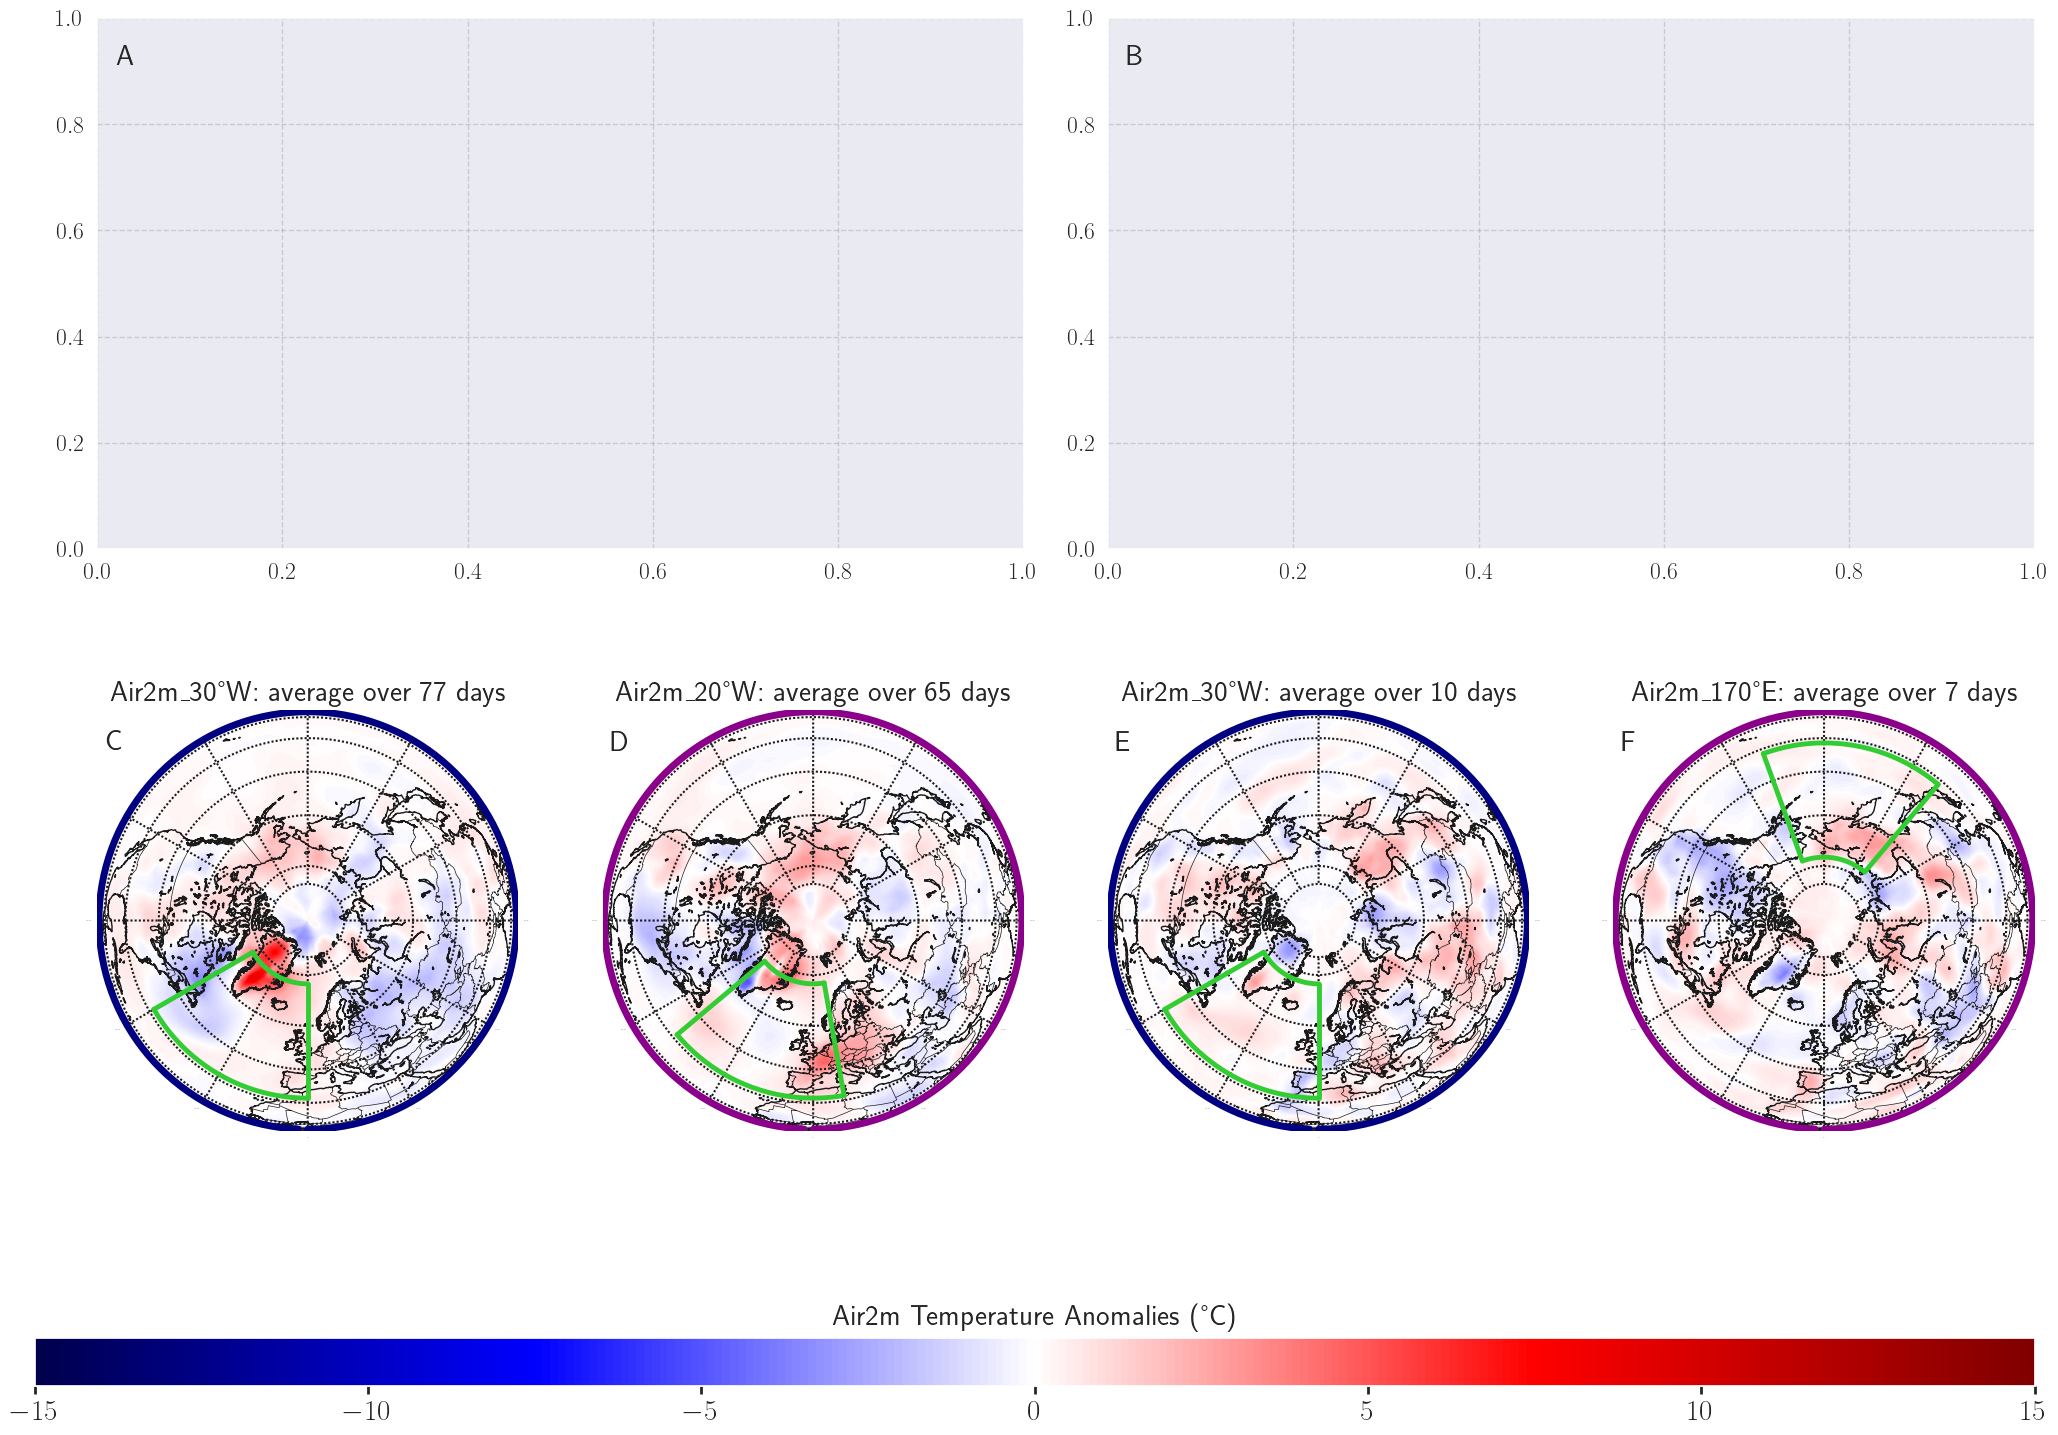

In [48]:
from pathlib import Path

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set up custom styles for the plots
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})
colors = ['navy', 'darkorange', 'limegreen', 'magenta','red','darkmagenta']

# Create 5x3 grid for the plots
fig, axs = plt.subplots(2, 4, figsize=(25, 16))
# First row with 2 subplots
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)

# Second row with 4 subplots
ax3 = plt.subplot2grid((2, 4), (1, 0))
ax4 = plt.subplot2grid((2, 4), (1, 1))
ax5 = plt.subplot2grid((2, 4), (1, 2))
ax6 = plt.subplot2grid((2, 4), (1, 3))


#####################

data_name = "Air2m_northern_DJF"
# Determine the season based on the file name
season = "Winter" if 'DJF' in data_name else "Summer"

# Get the current working directory, which is where the notebook is running from
current_script_path = Path(os.getcwd())
# Constants
grid_discretization = [37, 144]
scale = 360 / grid_discretization[1]
lati = range(13, 29 + 1)
filters = ["Lati_area", "Longi_Gaussian"]
n_microstates = 180
data_extension = ".npy"

max_NLPval_NearNeigh_numb = []
#%%!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
start = 90
clusterss = np.zeros((37,144,4))
longiss   = []
iloc=0
from Data_class1 import Data
for center_longitude in range(330, 350, 10):
    # Precompute longitude indices if cc is used
    longi, window_size = get_longitude_indices(center_longitude, 60)
    longiss.append(longi)
    # Create data object and process
    Data_ = Data(current_script_path, data_name, grid_discretization, data_extension, scale, lati, longi, window_size, season, filters, n_microstates)
    Data_.load_data()
    Data_.detrend_and_deseasonalize_data()
    Data_.get_blocked_days()
    Data_.scale_sqrt, grid_filter = Data_.calculate_distance_weights()
    
    # Detrended data analysis
    AIR2M_filtered_1951_74 = Data_.AIR2M_filtered[start:2130 + start, :, :][:, Data_.lati, :][:, :, Data_.longi].reshape((2130, -1)).copy() * Data_.scale_sqrt
    AIR2M_filtered_1999_22 = Data_.AIR2M_filtered[90 + 2130 * 2:, :, :][:, Data_.lati, :][:, :, Data_.longi].reshape((2130, -1)).copy() * Data_.scale_sqrt
    
    binary_sequences_future, neighbourhood_indexes = From_data_to_binary.create_binary_array_cdist(AIR2M_filtered_1999_22, AIR2M_filtered_1951_74, K_M, NUM_CORES)
    NLPval, kstar_ = compute_upsilon_values(binary_sequences_future, kstar_range=NEIGHBOR_RANGE, num_cores= NUM_CORES)
    
    
    
    # get an index of max 
    list1 = seasonal_anomalies['DJF']['anomalies_numb_future_detr'][degree_to_longitude(center_longitude)]['indices']
    imax = np.where( NLPval==NLPval.max()  )[0][0]
    # imax = np.where( NLPval>26  )[0][3]
    list2 = list(neighbourhood_indexes[imax,np.where(binary_sequences_future[imax,:]==True)[0]].astype(int))
    # Initialize the result list
    intersections1 = [value for value in list1 if value in list2]
    display(len(intersections1))
    max_NLPval_NearNeigh_numb.append(len(intersections1))
    clusterss[ :,:, iloc] = Data_.AIR2M_filtered[90 + 2130 * 2:, :, :][intersections1 ].mean(axis=0)
    iloc=iloc+1


# plt the results
visualize_microstate_mean_AIR2M(ax3,clusterss[:,:,0], longiss[0], colors[0], max_NLPval_NearNeigh_numb[0])
visualize_microstate_mean_AIR2M(ax4,clusterss[:,:,1], longiss[1], colors[5], max_NLPval_NearNeigh_numb[1])




###########


data_name = "Air2m_northern_JJA"

# Determine the season based on the file name
season = "Winter" if 'DJF' in data_name else "Summer"

# Get the current directory of the script
current_script_path = Path(os.getcwd())
# Constants
grid_discretization = [37, 144]
scale = 360 / grid_discretization[1]
lati = range(13, 29 + 1)
filters = ["Lati_area", "Longi_Gaussian"]
n_microstates = 180
data_extension = ".npy"

start = 90
clusterss = np.zeros((37,144,4))
longiss   = []
iloc=0
from Data_class1 import Data
for center_longitude in [330, 170]:
    # Precompute longitude indices if cc is used
    longi, window_size = get_longitude_indices(center_longitude, 60)
    longiss.append(longi)
    # Create data object and process
    Data_ = Data(current_script_path, data_name, grid_discretization, data_extension, scale, lati, longi, window_size, season, filters, n_microstates)
    Data_.load_data()
    Data_.detrend_and_deseasonalize_data()
    Data_.get_blocked_days()
    Data_.scale_sqrt, grid_filter = Data_.calculate_distance_weights()
    
    # Detrended data analysis
    AIR2M_filtered_1951_74 = Data_.AIR2M_filtered[start:2130 + start, :, :][:, Data_.lati, :][:, :, Data_.longi].reshape((2130, -1)).copy() * Data_.scale_sqrt
    AIR2M_filtered_1999_22 = Data_.AIR2M_filtered[90 + 2130 * 2:, :, :][:, Data_.lati, :][:, :, Data_.longi].reshape((2130, -1)).copy() * Data_.scale_sqrt
    
    binary_sequences_future, neighbourhood_indexes = From_data_to_binary.create_binary_array_cdist(AIR2M_filtered_1999_22, AIR2M_filtered_1951_74, K_M, NUM_CORES)
    NLPval, kstar_ = compute_upsilon_values(binary_sequences_future, kstar_range=NEIGHBOR_RANGE, num_cores= NUM_CORES)
    
    
    
    # get an index of max 
    list1 = seasonal_anomalies['JJA']['anomalies_numb_future_detr'][degree_to_longitude(center_longitude)]['indices']
    imax = np.where( NLPval==NLPval.max()  )[0][0]
    list2 = list(neighbourhood_indexes[imax,np.where(binary_sequences_future[imax,:]==True)[0]].astype(int))
    # Initialize the result list
    intersections1 = [value for value in list1 if value in list2]
    display(len(intersections1))
    max_NLPval_NearNeigh_numb.append(len(intersections1))
    clusterss[ :,:, iloc] = Data_.AIR2M_filtered[90 + 2130 * 2:, :, :][intersections1 ].mean(axis=0)
    iloc=iloc+1


# plt the results
visualize_microstate_mean_AIR2M(ax5,clusterss[:,:,0], longiss[0], colors[0], max_NLPval_NearNeigh_numb[2])
visualize_microstate_mean_AIR2M(ax6,clusterss[:,:,1], longiss[1], colors[5], max_NLPval_NearNeigh_numb[3])



labels = ['A', 'B', 'C', 'D', 'E', 'F']
for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='left')

# Ensure that the images in all subplots have the same color limits and colormap
for ax in [ax3, ax4, ax5, ax6]:
    im = ax.get_images()[0]  # Get the first image (from imshow)
    im.set_clim(-15, 15)     # Set the color limits
    im.set_cmap('seismic')   # Ensure the colormap is set to 'seismic'
    im.set_alpha(1)   # Ensure the colormap is set to 'seismic'

# Create a new axis below the second row for the colorbar
cbar_ax = fig.add_axes([0.1, 0.025, 0.8, 0.03])  # [left, bottom, width, height]

# Add the colorbar using one of the images
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# Add a title to the colorbar
cbar.set_label('Air2m Temperature Anomalies (°C)', fontsize=21,labelpad=10,fontweight='bold')  # Adjust the label and fontsize as needed
cbar.ax.xaxis.set_label_position('top')
# Set the correct ticks for the colorbar
cbar.set_ticks(np.arange(-10, 11, 5) )
# Set the tick size and thickness
cbar.ax.tick_params(labelsize=21, width=2)  # Adjust 'labelsize' and 'width' as needed

# Adjust the layout so that the subplots don't overlap with the colorbar
plt.subplots_adjust(bottom=0.15)